Google Colab上執行
SourceCode@Google Colab: https://colab.research.google.com/drive/1WHnj9rH6d2b_snSY31vNifJdmRAeGGzH  
參考:https://github.com/keras-team/keras-applications/tree/master/keras_applications

In [1]:
# _*_ coding: utf-8 _*_
# _*_ coding: cp950 _*_

# author: Chi-Hsu Chen (css920@gmail.com)

import numpy as np
import cv2
import time
from google.colab.patches import cv2_imshow

from keras import utils
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model,Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import Input,GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers import BatchNormalization,Activation,Dropout
from keras import layers
from keras import backend as K
from keras.layers import Lambda
from keras.layers import Concatenate

from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder

import keras

Using TensorFlow backend.


# pip install captcha

In [1]:
pip install captcha

     |████████████████████████████████| 102kB 2.8MB/s 


# 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, 'VDRM')

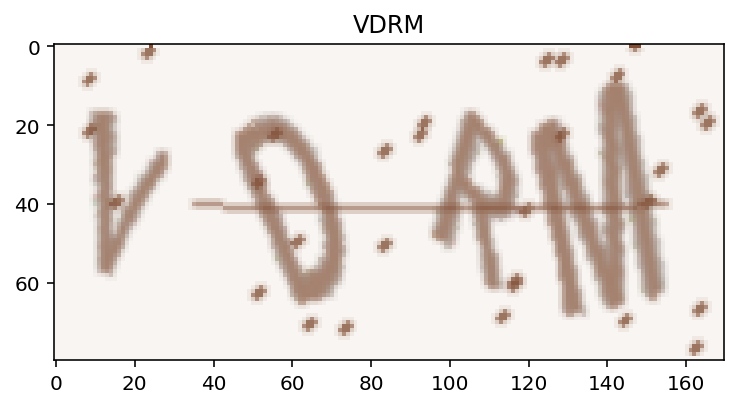

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)